In [1]:
import h5py, pathlib
from silx.io.dictdump import h5todict, dicttoh5
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pathlib

plt.style.use("bmh")

# %matplotlib inline
%matplotlib widget

In [2]:
run_dir = pathlib.Path("/ibira/lnls/beamlines/mogno/proposals/20233864/")
data_dir = run_dir / "data/KBfocus_Char_RHD_Experiment"

# data_dir = pathlib.Path("frames")

In [3]:
def read_scan(i_scan, read_frames=False):
    h5_fname = data_dir / f"KBfocus_Char_RHD_scan_{i_scan:04d}.hdf5"
    # print(h5_fname)
    if read_frames:
        with h5py.File(h5_fname) as f:
            # f.visititems(print)
            frames = np.array(f["entry/beamline/detector/pco_frames"])
    else:
        frames = None
    
    motion = h5todict(str(h5_fname), "entry/beamline/motion", asarray=False)
    return frames, motion

i_scan = 3
frames0, motion0 = read_scan(i_scan, read_frames=True)
fshape = frames0.shape[1:]

In [4]:
frames0.shape

(40, 2048, 2048)

In [ ]:
scan_ids = range(3, 495)
load_frames = True  # much faster, when not reading the frames (only motor positions)


if load_frames:
    frames = np.empty((len(scan_ids), len(frames0), *fshape), dtype=frames0.dtype)

positions = {key:[] for key in motion0}
wgx_pos = np.empty((len(scan_ids), len(frames0)))
wgy_pos = np.empty((len(scan_ids), len(frames0)))
wgz_pos = np.empty((len(scan_ids), len(frames0)))

for i, i_scan in enumerate(tqdm(scan_ids)):
    if load_frames:
        frames[i], motion = read_scan(i_scan, read_frames=True)
    else:
        _, motion = read_scan(i_scan)
    
    [positions[key].append(motion[key].mean()) for key in motion]
    wgx_pos[i] = motion["wgx"]
    wgy_pos[i] = motion["wgy"]
    wgz_pos[i] = motion["wgz"]

# wgx_pos = wgx_pos.reshape(12, 41, -1)
# wgy_pos = wgy_pos.reshape(12, 41, -1)
# wgz_pos = wgz_pos.reshape(12, 41, -1)

for key, p in positions.items():
    positions[key] = np.array(p)

  0%|          | 0/492 [00:00<?, ?it/s]

In [9]:
frames.shape

(492, 40, 2048, 2048)

## motor positions

  - wgz: position in direction of the x-ray beam (in mm), the focus being "somewhat close to zero"
  - wgx: horizontal position (in mm)
  - wgy: vertical position (in mm)

The scan consists of:
  - 12 wgz positions x 41 wgy positions x 40 wgx positions

Detector (PCO) positioned 1m from the focus.

(492, 40)
(492, 40)
(492, 40)


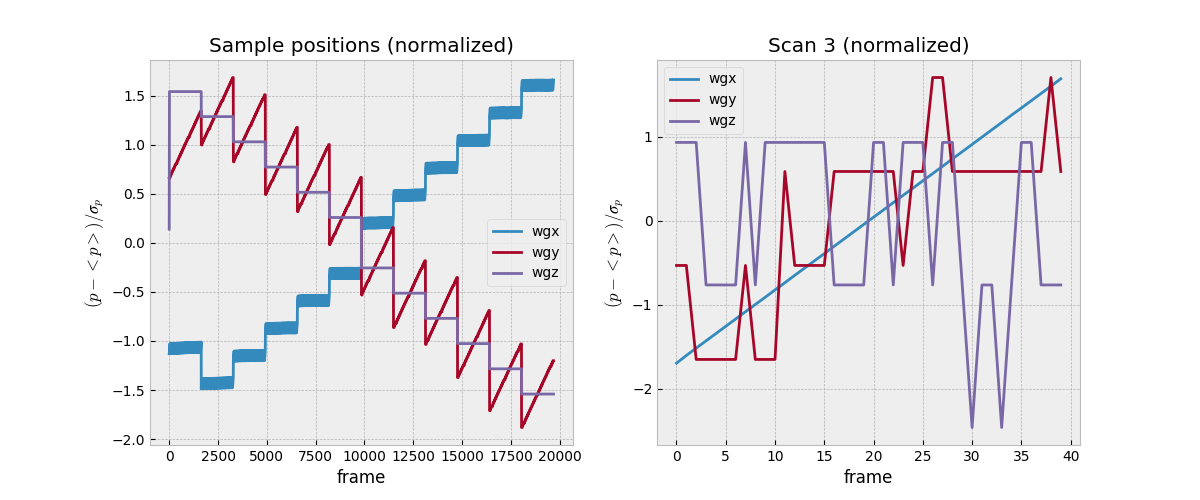

In [48]:
i_scan = 3
plt.figure(figsize=(12, 5))
labels = ("wgx", "wgy", "wgz")
for i, p in enumerate((wgx_pos, wgy_pos, wgz_pos)):
    plt.subplot(121)
    plt.plot(((p-p.mean()) / p.std()).ravel(), label=labels[i]);
    plt.legend()
    plt.ylabel("$(p - <p> ) / σ_p$")
    plt.xlabel("frame")
    plt.title("Sample positions (normalized)")
    
    plt.subplot(122)
    plt.plot(((p[i_scan]-p[i_scan].mean()) / p[i_scan].std()).ravel(), label=labels[i]);
    plt.ylabel("$(p - <p> ) / σ_p$")
    plt.xlabel("frame")
    plt.title(f"Scan {i_scan} (normalized)")
    plt.legend()
    print(p.shape)

In [49]:
wgx_pos.shape, wgy_pos.shape, wgz_pos.shape, frames.shape

((492, 40), (492, 40), (492, 40), (492, 40, 2048, 2048))

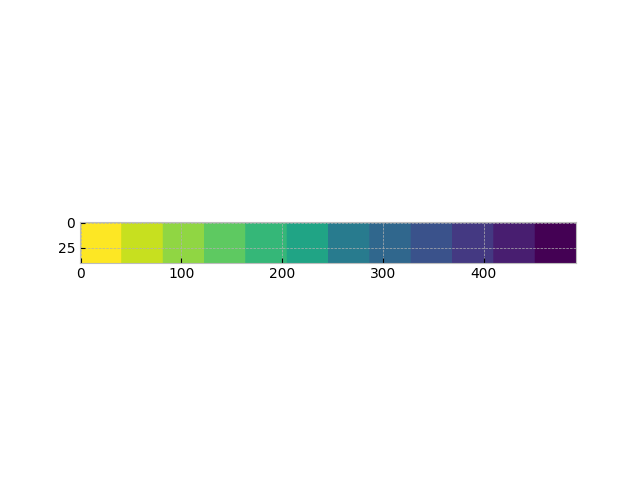

In [50]:
fig, ax = plt.subplots()
ax.imshow(wgz_pos[:,:].T)
wgz_pos[41:82,:]
A = 41
B = 82

In [24]:
data = frames[41:82,:,:,:]

## vizualize frames 
(have to be loaded first)

In [25]:
import napari
# v = napari.view_image(frames)

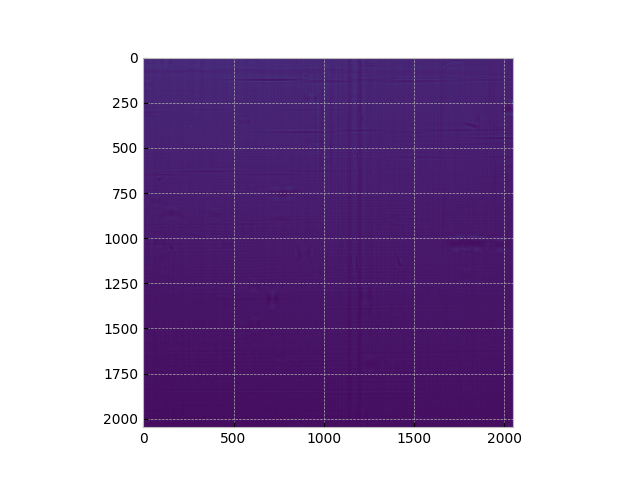

In [27]:
empty = data.mean((0, 1)).astype(np.float32)

fig, ax = plt.subplots(1)
ax.imshow(empty)
np.save('empty.npy',empty)

In [28]:
import sscCdi
%matplotlib widget

In [33]:
data = data.reshape(data.shape[0]*data.shape[1],data.shape[2],data.shape[3])
data.shape

(1640, 2048, 2048)

In [34]:
sscCdi.deploy_visualizer(data,axis=0)

In [ ]:
if 0:
    projs = frames / empty
else:
    projs = frames
    
projs.shape

In [31]:
# v = napari.view_image(projs)

In [37]:
positions_x = wgx_pos[A:B,:].flatten()
positions_y = wgy_pos[A:B,:].flatten()
positions_z = wgz_pos[A:B,:].flatten()
positions = np.vstack((positions_y,positions_x)).T
positions.shape

(1640, 2)

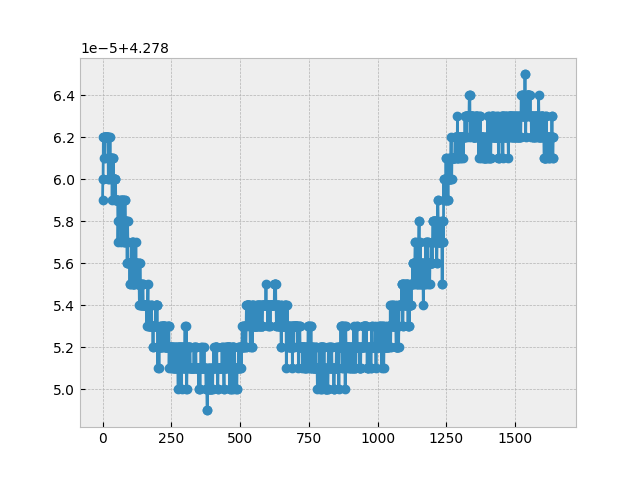

In [38]:
fig, ax = plt.subplots()
ax.plot(positions_z,'-o')

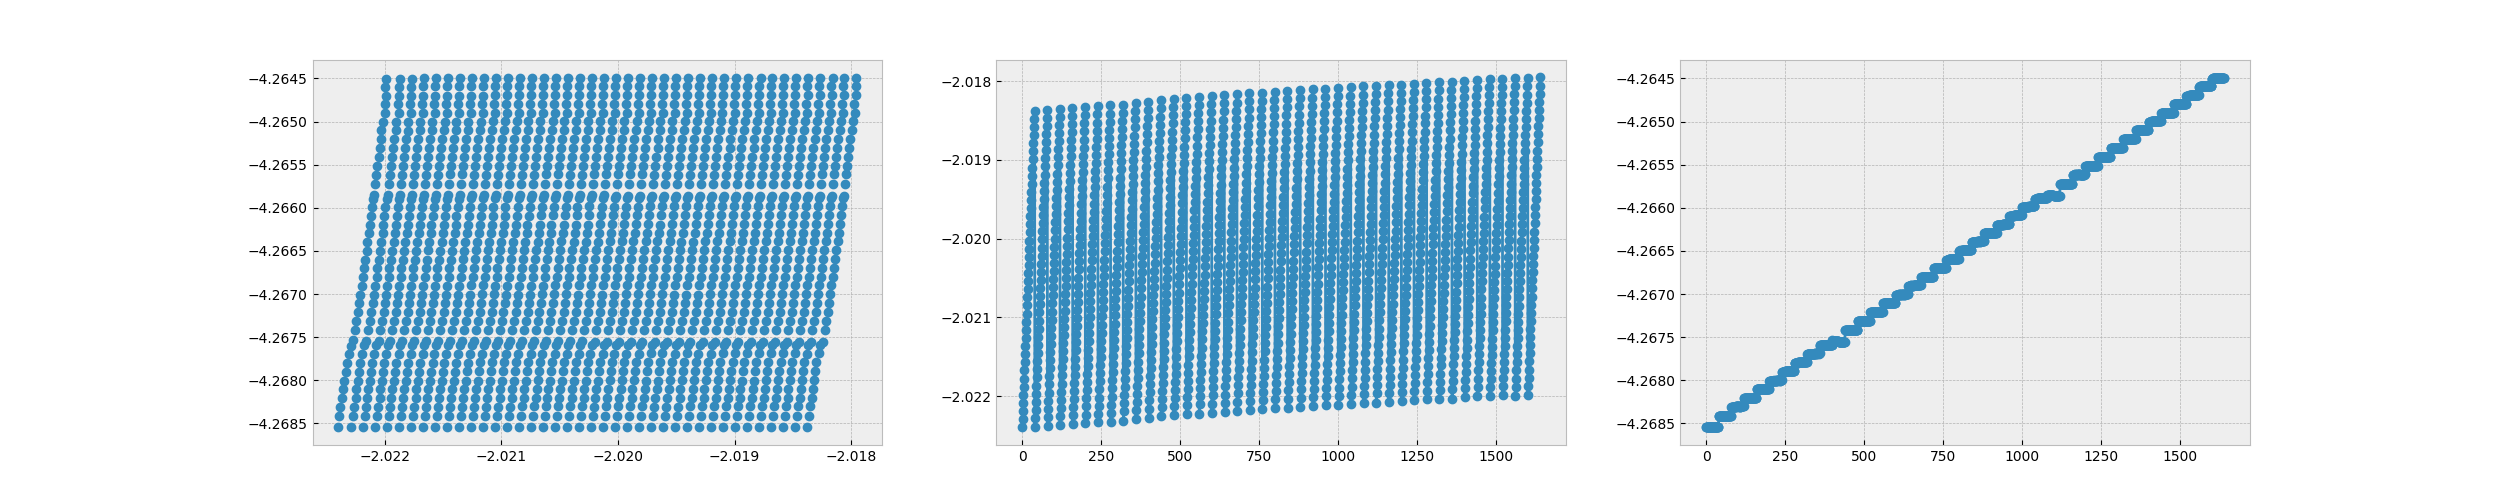

In [47]:
fig, ax = plt.subplots(1,3,figsize=(25,5))
ax[0].plot(positions_x,positions_y,'o')
ax[1].plot(positions_x,'o-')
ax[2].plot(positions_y,'o-')

In [51]:
np.save('positions.npy', positions)
np.save('z_positions.npy',positions_z)
np.save('data.npy',data)

In [41]:
print(data.shape)

size_in_bytes = data.nbytes

# Convert the size to gigabytes
size_in_gb = size_in_bytes / (1024**3)

print("Size of the array:", size_in_gb, "GB")

(1640, 2048, 2048)
Size of the array: 12.8125 GB


In [52]:
positions_z

array([4.278059, 4.27806 , 4.27806 , ..., 4.278061, 4.278062, 4.278062])